Epoch 1/50
1151/1151 [==============================] - 3s 2ms/step - loss: 0.5981 - val_loss: 0.5538
Epoch 2/50
1151/1151 [==============================] - 2s 2ms/step - loss: 0.5526 - val_loss: 0.5514
Epoch 3/50
1151/1151 [==============================] - 2s 2ms/step - loss: 0.5504 - val_loss: 0.5483
Epoch 4/50
1151/1151 [==============================] - 2s 2ms/step - loss: 0.5473 - val_loss: 0.5468
Epoch 5/50
1151/1151 [==============================] - 2s 2ms/step - loss: 0.5462 - val_loss: 0.5454
Epoch 6/50
1151/1151 [==============================] - 2s 2ms/step - loss: 0.5455 - val_loss: 0.5449
Epoch 7/50
1151/1151 [==============================] - 2s 2ms/step - loss: 0.5451 - val_loss: 0.5448
Epoch 8/50
1151/1151 [==============================] - 2s 2ms/step - loss: 0.5447 - val_loss: 0.5447
Epoch 9/50
1151/1151 [==============================] - 2s 2ms/step - loss: 0.5446 - val_loss: 0.5443
Epoch 10/50
1151/1151 [==============================] - 2s 2ms/step - loss: 0.544

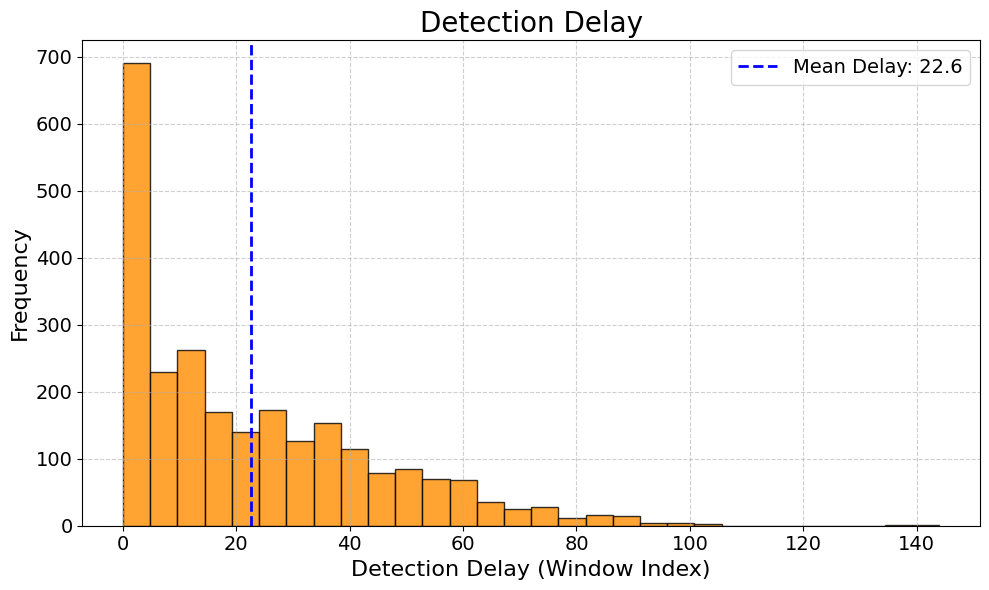

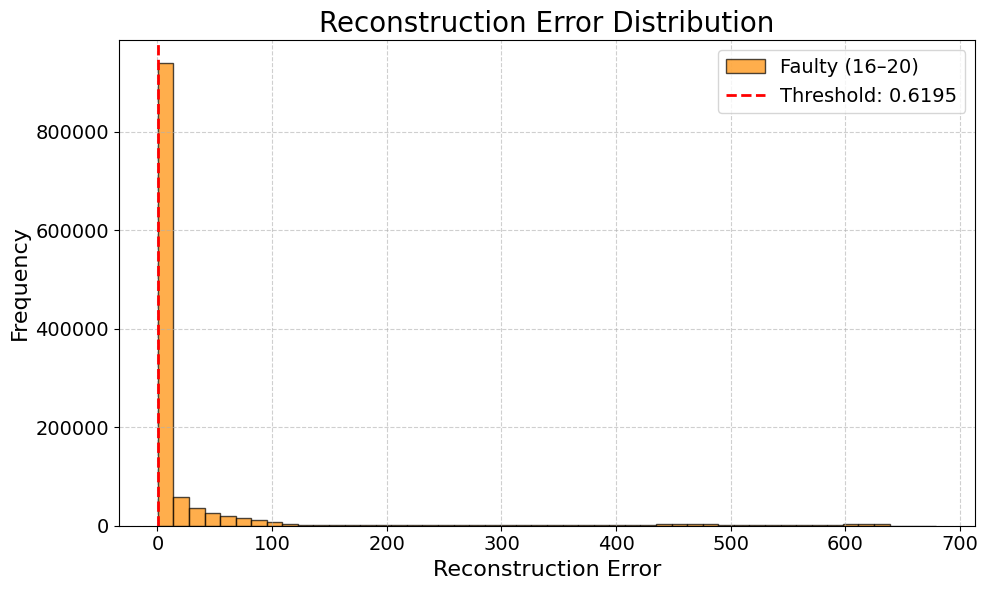

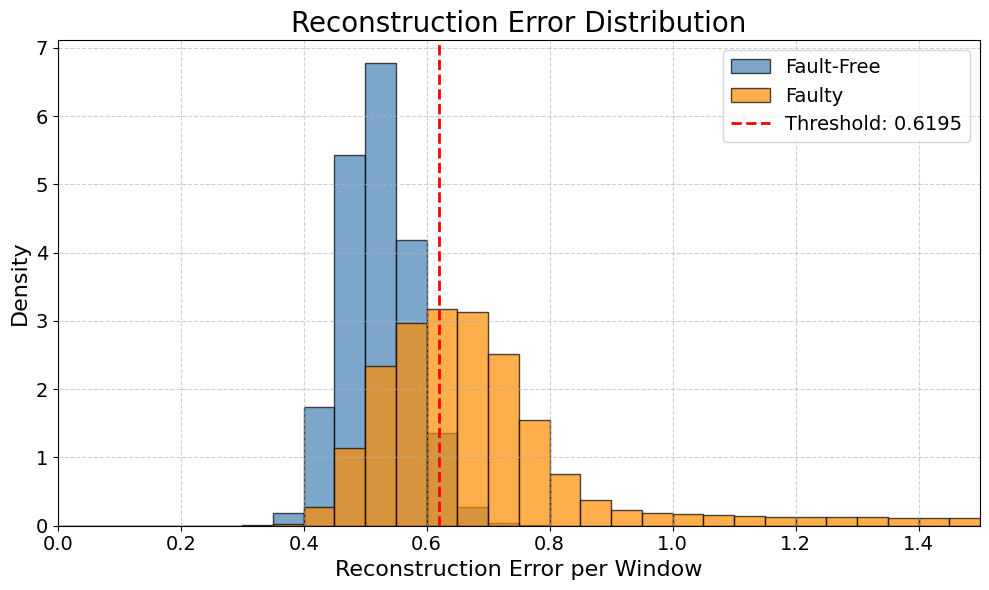

Manual Threshold (Percentile 95): 0.619477
ROC AUC: 0.9132
Test Evaluation Time: 32.732 seconds

Classification Report:
              precision    recall  f1-score   support

         0.0     0.1393    0.9656    0.2434     49100
         1.0     0.9981    0.7517    0.8575   1180000

    accuracy                         0.7602   1229100
   macro avg     0.5687    0.8587    0.5505   1229100
weighted avg     0.9638    0.7602    0.8330   1229100



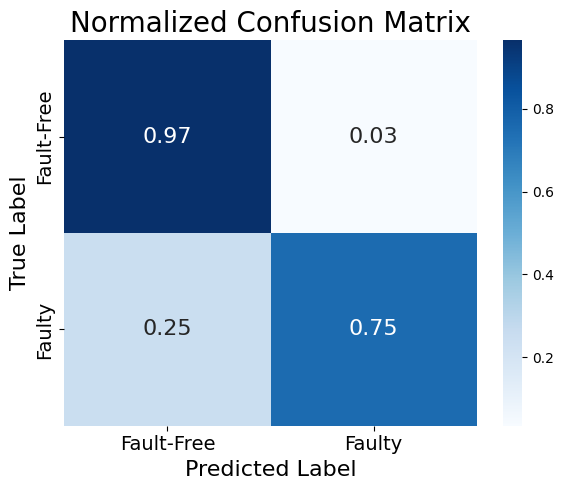

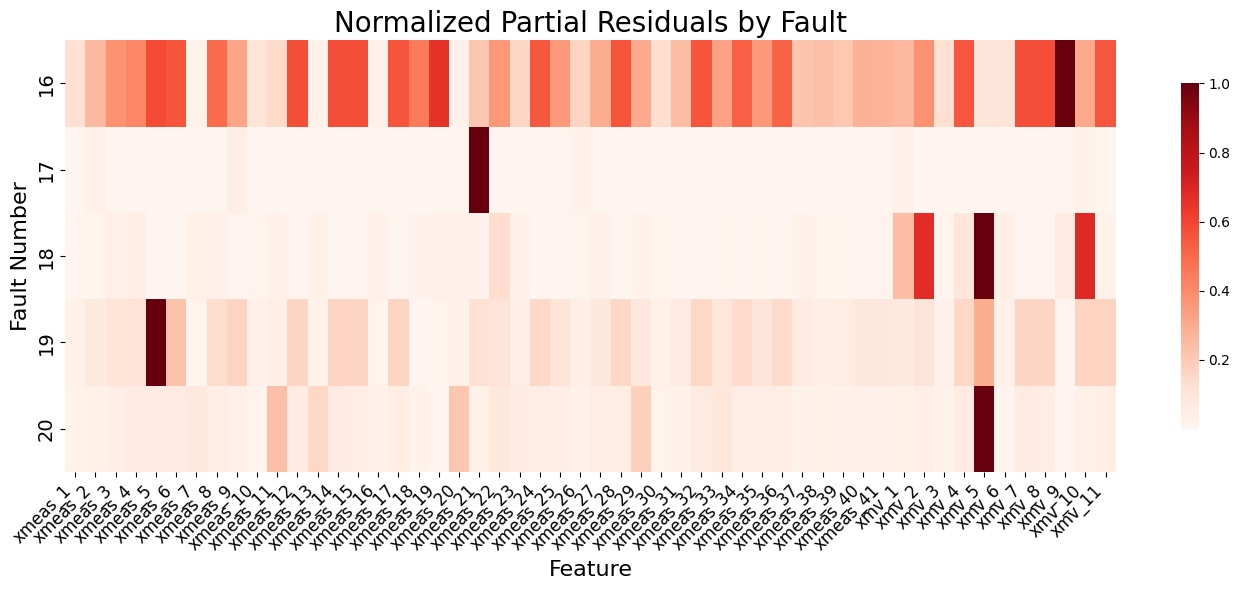

In [6]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, auc, roc_curve, ConfusionMatrixDisplay)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Configuration
WINDOW_SIZE = 10
FAULTY_START_SAMPLE = 20
MANUAL_THRESHOLD_PERCENTILE = 95

# Load Tennessee Eastman Process data
ff_train = pd.read_pickle("TEP_FaultFree_Training_fault_free_training.pkl")
f_train = pd.read_pickle("TEP_Faulty_Training_faulty_training.pkl")

# Sensor feature columns
feature_cols = [col for col in ff_train.columns if col not in ['simulationRun', 'sample', 'faultNumber']]

# Function to create rolling windows from each simulation run
def make_windows(df, feature_cols, window_size=10, min_sample=0, return_metadata=False):
    sequences, run_ids, fault_nums, sample_ids = [], [], [], []
    for run_id, group in df.groupby("simulationRun"):
        group = group.sort_values("sample")
        fault_number = group["faultNumber"].iloc[0] if "faultNumber" in group.columns else 0
        group = group[group["sample"] >= min_sample]
        data = group[feature_cols].values
        samples = group["sample"].values
        if len(data) < window_size:
            continue
        for i in range(window_size - 1, len(data)):
            window = data[i - window_size + 1:i + 1].flatten()
            sequences.append(window)
            if return_metadata:
                run_ids.append(run_id)
                fault_nums.append(fault_number)
                sample_ids.append(samples[i])
    if return_metadata:
        return np.array(sequences), np.array(run_ids), np.array(fault_nums), np.array(sample_ids)
    return np.array(sequences)

# Train/validation/test split on fault-free runs
ff_runs = ff_train["simulationRun"].unique()
train_runs, temp_runs = train_test_split(ff_runs, test_size=0.4, random_state=42)
val_runs, test_ff_runs = train_test_split(temp_runs, test_size=0.5, random_state=42)

ff_train_sub = ff_train[ff_train["simulationRun"].isin(train_runs)].copy()
ff_val_sub   = ff_train[ff_train["simulationRun"].isin(val_runs)].copy()
ff_test_sub  = ff_train[ff_train["simulationRun"].isin(test_ff_runs)].copy()

# Normalize features using fault-free training set
scaler = StandardScaler()
scaler.fit(ff_train_sub[feature_cols])
for df in [ff_train_sub, ff_val_sub, ff_test_sub, f_train]:
    df[feature_cols] = scaler.transform(df[feature_cols])

# Create windowed sequences
X_train = make_windows(ff_train_sub, feature_cols, WINDOW_SIZE)
X_val   = make_windows(ff_val_sub, feature_cols, WINDOW_SIZE)
X_test_ff = make_windows(ff_test_sub, feature_cols, WINDOW_SIZE)

# Filter and remap unknown fault runs
f_test_sub = f_train[f_train['faultNumber'].isin([16, 17, 18, 19, 20])].copy()
f_test_sub["simulationRun"] = f_test_sub["faultNumber"] * 1000 + f_test_sub["simulationRun"]
X_test_faulty, run_ids_faulty, fault_nums_faulty, _ = make_windows(f_test_sub, feature_cols, WINDOW_SIZE, min_sample=FAULTY_START_SAMPLE, return_metadata=True)

# Combine fault-free and faulty test sets
X_test = np.vstack([X_test_ff, X_test_faulty])
y_test = np.hstack([np.zeros(len(X_test_ff)), np.ones(len(X_test_faulty))])

# Build autoencoder
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_val, X_val), shuffle=True)

# Evaluate test reconstruction error
start_time = time.time()
X_test_recon = autoencoder.predict(X_test)
recon_error = np.mean(np.square(X_test - X_test_recon), axis=1)

# Determine threshold from validation set
X_val_recon = autoencoder.predict(X_val)
val_recon_error = np.mean(np.square(X_val - X_val_recon), axis=1)
manual_thresh = np.percentile(val_recon_error, MANUAL_THRESHOLD_PERCENTILE)

# ROC AUC score
fpr, tpr, _ = roc_curve(y_test, recon_error)
roc_auc = auc(fpr, tpr)

# Classify as fault based on reconstruction error + smoothing
y_pred_raw = (recon_error > manual_thresh).astype(int)
y_pred_stable = np.zeros_like(y_pred_raw)
for i in range(1, len(y_pred_raw)):
    if y_pred_raw[i - 1] == 1 and y_pred_raw[i] == 1:
        y_pred_stable[i - 1] = 1
        y_pred_stable[i] = 1

# Detection delay calculation
meta_df = pd.DataFrame({
    "run_id": run_ids_faulty,
    "y_pred": y_pred_stable[len(X_test_ff):]
})
detected_delays = []
for run_id, group in meta_df.groupby("run_id"):
    preds = group["y_pred"].values
    detection_idx = np.where(preds == 1)[0]
    if len(detection_idx) > 0:
        detected_delays.append(detection_idx[0])

# Plot detection delay histogram
plt.figure(figsize=(10, 6))
plt.hist(detected_delays, bins=30, color='darkorange', edgecolor='black', alpha=0.8)
mean_delay = np.mean(detected_delays)
plt.axvline(mean_delay, color='blue', linestyle='--', linewidth=2, label=f'Mean Delay: {mean_delay:.1f}')
plt.title("Detection Delay", fontsize=20)
plt.xlabel("Detection Delay (Window Index)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot reconstruction error for faulty windows
plt.figure(figsize=(10, 6))
plt.hist(recon_error[y_test == 1], bins=50, alpha=0.7, label='Faulty (16â€“20)', color='darkorange', edgecolor='black')
plt.axvline(manual_thresh, color='red', linestyle='--', linewidth=2, label=f'Threshold: {manual_thresh:.4f}')
plt.title("Reconstruction Error Distribution", fontsize=20)
plt.xlabel("Reconstruction Error", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Zoomed reconstruction error distribution with normalized Y-axis
bin_edges = np.arange(0, 1.55, 0.05)
plt.figure(figsize=(10, 6))
plt.hist(recon_error[y_test == 0], bins=bin_edges, alpha=0.7, label='Fault-Free',color='steelblue', edgecolor='black', density=True)
plt.hist(recon_error[y_test == 1], bins=bin_edges, alpha=0.7, label='Faulty',color='darkorange', edgecolor='black', density=True)
plt.axvline(manual_thresh, color='red', linestyle='--', linewidth=2,label=f'Threshold: {manual_thresh:.4f}')
plt.title("Reconstruction Error Distribution", fontsize=20)
plt.xlabel("Reconstruction Error per Window", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 1.5)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Print evaluation results
print(f"Manual Threshold (Percentile {MANUAL_THRESHOLD_PERCENTILE}): {manual_thresh:.6f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Test Evaluation Time: {time.time() - start_time:.3f} seconds")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_stable, digits=4)}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_stable, normalize='true')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Fault-Free", "Faulty"], yticklabels=["Fault-Free", "Faulty"], annot_kws={"size": 16})
plt.title("Normalized Confusion Matrix", fontsize=20)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# Partial residuals for root cause visualization
X_test_faulty_recon = X_test_recon[len(X_test_ff):]
X_test_faulty_true = X_test[len(X_test_ff):]
residuals = np.square(X_test_faulty_true - X_test_faulty_recon)
reshaped = residuals.reshape((-1, WINDOW_SIZE, len(feature_cols)))
avg_residuals = reshaped.mean(axis=1)
partial_df = pd.DataFrame(avg_residuals, columns=feature_cols)
partial_df["faultNumber"] = fault_nums_faulty
grouped = partial_df.groupby("faultNumber").mean()
normalized = grouped.divide(grouped.max(axis=1), axis=0)

# Plot heatmap of top contributing features by fault type
plt.figure(figsize=(14, 6))
sns.heatmap(normalized, cmap="Reds", xticklabels=True, yticklabels=True, cbar_kws={"shrink": 0.8})
plt.title("Normalized Partial Residuals by Fault", fontsize=20)
plt.xlabel("Feature", fontsize=16)
plt.ylabel("Fault Number", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()